### 1. Load all the necessary libraries

mne is a python library for MEG and EEG data analysis. It is based on the FIF file format from MNE-C. It provides a convenient way to browse, filter, epoch and average MEG and EEG data, and also to estimate evoked responses and cortical activity from sensor space data using dSPM and sLORETA. It also includes a GUI for source localization.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import mne

from IPython.display import Markdown as md

### 2. Data Preprocessing

#### 2.1. Load the data

In [6]:
#load .gdf file
raw = mne.io.read_raw_gdf('../data/ecg_data/A01T.gdf', preload=True, verbose=False)

/home/pops/anaconda3/lib/python3.9/contextlib.py:126: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


#### 2.2 Find the events

In [7]:
events = mne.events_from_annotations(raw)

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


events is a tuple of two  elements. The first element is an array of event times in samples. The second element is an dictionary of event codes. The keys are the event codes and the values are the event names.

In [8]:
print(events[1])

{'1023': 1, '1072': 2, '276': 3, '277': 4, '32766': 5, '768': 6, '769': 7, '770': 8, '771': 9, '772': 10}


events[0] is a 2d array where the first column contains the sample index when the event occurred. The second column contains the value of the trigger channel immediately before the event occurred. The third column contains the event-id.

In [9]:
events[0]

array([[     0,      0,      5],
       [     0,      0,      3],
       [ 29683,      0,      5],
       ...,
       [670550,      0,      6],
       [670550,      0,      1],
       [671050,      0,      7]])

#### 2.3. Epoch the data: make windows of data around the events

Let's make a dictionary of event names and their corresponding event ids. This will be useful for later.

In [10]:
event_id = {'Left Hand': 7, 'Right Hand': 8, 'Feet': 9, 'Tongue': 10}

In [11]:
#extract windows for each event
epochs = mne.Epochs(raw, events[0], event_id, tmin=-0.5, tmax=4.1, baseline=None, preload=True)

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1151 original time points ...
0 bad epochs dropped


In [12]:
#convert the epochs to a data frame
df = epochs.to_data_frame()
df.head()

,time,condition,epoch,EEG-Fz,EEG-0,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5,...,EEG-11,EEG-12,EEG-13,EEG-14,EEG-Pz,EEG-15,EEG-16,EOG-left,EOG-central,EOG-right
0,-0.500,Tongue,8,6.933594,7.617188,6.542969,8.789062,6.542969,6.591797,3.710938,...,6.054688,5.908203,7.958984,4.003906,4.541016,6.250000,3.759766,-1.464844,16.113281,-4.882812
1,-0.496,Tongue,8,3.808594,3.662109,2.929688,4.296875,3.906250,3.173828,2.050781,...,2.734375,4.785156,6.298828,1.806641,2.978516,4.736328,1.562500,3.417969,14.160156,-5.371094
2,-0.492,Tongue,8,-2.636719,-2.490234,-5.224609,-3.564453,-5.664062,-5.419922,-3.369141,...,-5.468750,-7.177734,-5.029297,-8.398438,-7.910156,-6.933594,-9.228516,-0.976562,15.625000,-4.394531
3,-0.488,Tongue,8,-10.644531,-8.007812,-12.451172,-10.791016,-13.037109,-10.791016,-6.835937,...,-9.570312,-10.156250,-9.082031,-8.642578,-9.375000,-8.935547,-9.082031,-5.859375,3.906250,-16.601562
4,-0.484,Tongue,8,-3.955078,-7.324219,-6.103516,-8.203125,-5.078125,-6.250000,-1.611328,...,-4.101562,-3.076172,-2.001953,-1.074219,-2.734375,-2.587891,-3.222656,-1.464844,6.347656,-15.625000


Let's check how long is each epoch

In [13]:
df['epoch'].value_counts()

8      1151
10     1151
414    1151
412    1151
410    1151
       ... 
205    1151
203    1151
200    1151
198    1151
602    1151
Name: epoch, Length: 288, dtype: int64

In [14]:
md(f'Each epoch has {df["epoch"].value_counts().values[0]} samples')

Each epoch has 1151 samples

Let's check how many samples each event type has.

In [15]:
df['condition'].value_counts()/1151

Tongue        72.0
Feet          72.0
Right Hand    72.0
Left Hand     72.0
Name: condition, dtype: float64

We can also convert the raw data to pandas dataframe.

In [16]:
#convert to pandas dataframe
df = raw.to_data_frame()

In [17]:
df.head()

,time,EEG-Fz,EEG-0,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5,EEG-C3,EEG-6,...,EEG-11,EEG-12,EEG-13,EEG-14,EEG-Pz,EEG-15,EEG-16,EOG-left,EOG-central,EOG-right
0,0.000,-21.142578,-23.681641,-21.484375,-25.146484,-25.732422,-27.929688,-14.550781,-22.509766,-25.439453,...,-30.615234,-29.638672,-26.660156,-20.947266,-25.439453,-24.902344,-19.677734,31.738281,-13.671875,-43.945312
1,0.004,-21.923828,-23.925781,-24.316406,-25.341797,-26.074219,-25.244141,-16.064453,-22.753906,-28.320312,...,-31.054688,-30.712891,-26.123047,-22.998047,-27.099609,-26.367188,-23.339844,22.460938,-13.183594,-40.527344
2,0.008,-15.625000,-19.726562,-18.847656,-21.582031,-20.751953,-21.728516,-12.451172,-20.410156,-23.730469,...,-28.759766,-28.417969,-24.462891,-21.386719,-25.097656,-24.267578,-21.484375,33.691406,-8.300781,-38.574219
3,0.012,-16.699219,-13.720703,-20.361328,-20.849609,-24.169922,-22.021484,-10.986328,-16.357422,-25.585937,...,-27.783203,-28.857422,-25.537109,-19.335937,-24.316406,-24.511719,-17.919922,41.992188,-7.324219,-38.574219
4,0.016,-19.335937,-17.626953,-20.410156,-26.464844,-27.392578,-29.882812,-9.277344,-18.359375,-24.609375,...,-31.884766,-33.740234,-32.666016,-18.554688,-26.611328,-28.466797,-18.408203,37.109375,-15.136719,-49.804688


We can directly plot the raw data using the plot method of the raw object.

Using matplotlib as 2D backend.


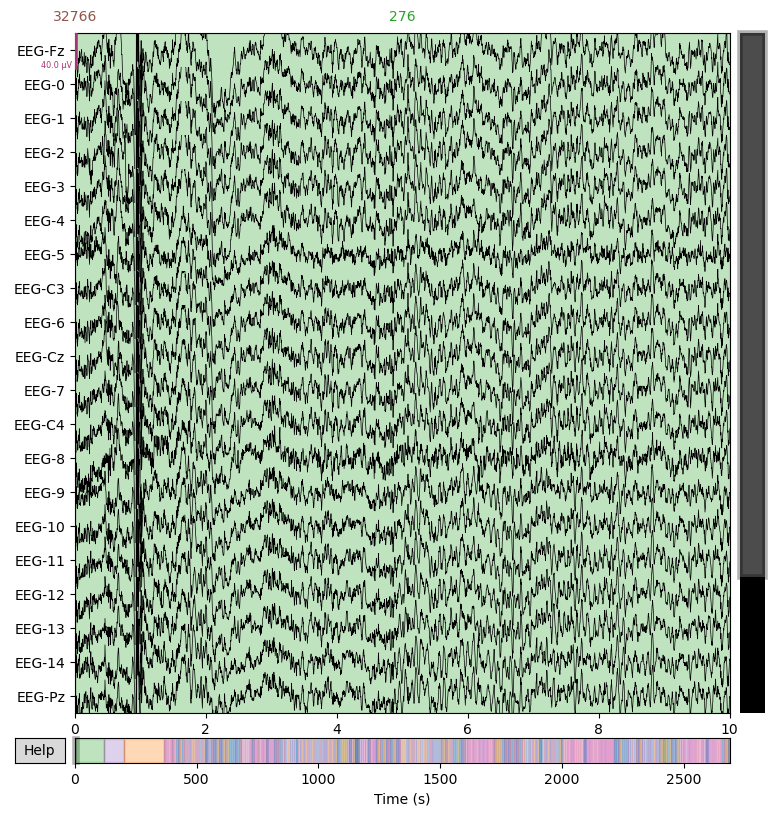

In [18]:
raw.plot();